In [1]:
from qutip import *

from scipy.optimize import curve_fit as cf

import numpy as np
from numpy import pi as pi
from numpy import sqrt as sqrt

import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

In [2]:
def Rs(t,p):
    t = t/180*np.pi
    p = p/180*np.pi
    return np.array([np.sin(t)*np.cos(p), np.sin(t)*np.sin(p), np.cos(t)])    

def Rx(tx):
    tx = tx/180*np.pi
    Rx = np.array([[1,0,0],
                   [0,np.cos(tx),-np.sin(tx)],
                   [0,np.sin(tx), np.cos(tx)]])
    return Rx

def Rz(tz):
    tz= tz/180*np.pi
    Rz = np.array([[np.cos(tz), -np.sin(tz), 0],
                   [np.sin(tz), np.cos(tz), 0],
                   [0, 0, 1]])    
    return Rz

def Eigenbasis_Expansion(H):
    Q = np.zeros(H.shape, dtype=np.complex)
    for i, ev in enumerate(H.eigenstates()[1]):    
        Q[:,i] = ev.full().flatten()    
    return Q

In [3]:
def boltzmann(E, T):
    h = 6.626e-34
    kB = 1.38e-23
    return np.exp(-h*E/(kB*T))

def coth(gs, T):
    h = 6.626e-34
    kB = 1.38e-23
    return np.tanh(h*gs*1e9/(2*kB*T))**(-1)

def lorentzian(nu, nu0, Gamma, A, c):
    return A*(Gamma/2)**2/((nu-nu0)**2+(Gamma/2)**2) + c 

def gaussian(nu, nu0, sigma, A, c):
    return A*1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(nu-nu0)**2/(2*sigma**2)) + c

def pulse_seq(t, width, t0=0, tau=0, N=1):
    seq = np.zeros(t.shape)
    starts = []
    stops = []
    for n in range(N):
        starts.append(t0)
        stops.append(t0+width)
        seq += np.where( (t>=t0)&(t<t0+width), 1, 0)        
        t0 = t0 + width
        t0 += (n+1)*tau
    
    starts = np.array(starts)
    stops = np.array(stops)
    return starts, stops, seq

In [4]:
egx = basis(4, 0)
egy = basis(4, 1)
eux = basis(4, 2)
euy = basis(4, 3)

sgx = egx*egy.dag()
sgx += sgx.dag()
sgy = -1j*egx*egy.dag()
sgy += sgy.dag()
sgz = egx*egx.dag() - egy*egy.dag()
sux = eux*euy.dag()
sux += sux.dag()
suy = -1j*eux*euy.dag()
suy += suy.dag()
suz = eux*eux.dag() - euy*euy.dag()

egp = 1/np.sqrt(2)*(egx + 1j*egy)
egm = 1/np.sqrt(2)*(egx - 1j*egy)
eup = 1/np.sqrt(2)*(eux + 1j*euy)
eum = 1/np.sqrt(2)*(eux - 1j*euy)

su = basis(2,0)
sd = basis(2,1)
Sx = su*sd.dag() + sd*su.dag()
Sy = -1j*su*sd.dag() + 1j*sd*su.dag()
Sz = su*su.dag() - sd*sd.dag()

Iu = basis(2,0)
Id = basis(2,1)
Ix = Iu*Id.dag() + Id*Iu.dag()
Iy = -1j*Iu*Id.dag() + 1j*Id*Iu.dag()
Iz = Iu*Iu.dag() - Id*Id.dag()

In [5]:
sgx = tensor(sgx, qeye(2))
sgy = tensor(sgy, qeye(2))
sgz = tensor(sgz, qeye(2))
sux = tensor(sux, qeye(2))
suy = tensor(suy, qeye(2))
suz = tensor(suz, qeye(2))
Sx = tensor(qeye(4), Sx)
Sy = tensor(qeye(4), Sy)
Sz = tensor(qeye(4), Sz)

# Ix = tensor(qeye(4), qeye(2), Ix)
# Iy = tensor(qeye(4), qeye(2), Iy)
# Iz = tensor(qeye(4), qeye(2), Iz)

In [6]:
sigm_x = egp*eum.dag() + egm*eup.dag()
sigm_x = tensor(sigm_x, qeye(2))
sigp_x = sigm_x.dag()
px = sigm_x+sigp_x

sigm_y = 1j*egp*eum.dag() -1j* egm*eup.dag()
sigm_y = tensor(sigm_y, qeye(2))
sigp_y = sigm_y.dag()
py = sigm_y+sigp_y

sigm_z = 2*(egp*eup.dag() + egm*eum.dag())
sigm_z = tensor(sigm_z, qeye(2))
sigp_z = sigm_z.dag()
pz = sigm_z + sigp_z

In [8]:
h = 6.626e-34
c = 299792458
e = 1.62e-19
T = 5

# Bare coulomb splitting of Eg and Eu states
w_C = 2*pi*c/736.85

# Spin-orbit couplings
lbd_SO_g = 2*pi*46
lbd_SO_u = 2*pi*250

# (Transverse) Strain couplings
alpha_g = 2*pi*30
beta_g = 2*pi*20

alpha_u = 2*pi*1.8/1.3*alpha_g
beta_u = 2*pi*2*beta_g

# Magnetons and gyromagnetic ratio for electron and nuclear spin
muB = 2*pi*9.274e-24/h * 1e-9
muN = 2*pi*5.505e-23/h * 1e-9
g_e = 2
g_n = 1.910*0

# Orbital angular momentum quenching factor (phenomenological)
q = 0.1

# Nuclear spin coupling strengths along and perpendicular to the electron spin quantization axis 
# (which might be different from the SiV symmmetry axis)
A_para = 0*50e-3
A_perp = 0*100e-3

# SiV orientation (theta, phi) with respect to external lab frame, where z defines the optical axis
# theta_x = 54.7 and theta_z = 45 corresponds to a <111> crystal direction
theta_x = 54.7
theta_z = 45

# We can use a transformation matrix which transforms coordinates such that 111 --> 001, i.e. in this reference
# frame the SiV symmetry axis is pointing along z
# Rz(-theta_z)@Rx(-theta_x)

In [10]:
B = 0.3
B_theta = 54.7
B_phi = 45
bx, by, bz = Rx(theta_x)@Rz(theta_z)@Rs(B_theta, B_phi)
Bx = B*bx
By = B*by
Bz = B*bz    

HC = w_C/2*tensor(eux*eux.dag() + euy*euy.dag() - egx*egx.dag() - egy*egy.dag(), qeye(2))

HSO = -lbd_SO_g/2 * sgy * Sz -lbd_SO_u/2 * suy * Sz

HZS = g_e * muB/2 * (Sx * Bx + Sy * By + Sz * Bz)
HZL = -0.13 * muB * (-sgy - suy) * Bz

HStr = alpha_g*sgz + beta_g*sgx + alpha_u*suz + beta_g*sux

H = HC + HSO + HZS + HZL + HStr    
H = H.tidyup(1e-10)
engs, evs = H.eigenstates()

In [ ]:
pwidth = 100
ptau = 100
pN = 10
pL = pN * pwidth + np.sum(np.arange(1,pN,1))*ptau
starts, stops, seq = pulse_seq(tlist, pwidth, tau=ptau, N=pN)

In [14]:
Gamma_opt = 1/(2*pi*1.73)
Gamma_phon_g0 = 1/(2*pi*40)
Gamma_phon_u0 = 1/(2*pi*0.4)
Gamma_spin = 1/(2*pi*1e3)

gs0 = lbd_SO_g
gs = engs[2] - engs[0]
es = engs[6] - engs[4]

Gamma_phon_g = Gamma_phon_g0*(gs/gs0)**3 * coth(gs,T) / coth(gs0,T)
Gamma_phon_g = Gamma_phon_g
print("Extrapolated T1: ", 1/(2*pi*Gamma_phon_g), "at ", gs/(2*pi),"GHz splitting")

es0 = lbd_SO_u
Gamma_phon_u = Gamma_phon_u0*(es/es0)**3 * coth(es,T) / coth(es0,T)

c_ops = []

# Optical decays defined from SO basis (only Emission relevant)
c_ops.append(np.sqrt(Gamma_opt)*sigm_x)
c_ops.append(np.sqrt(Gamma_opt)*sigm_y)
c_ops.append(np.sqrt(Gamma_opt)*sigm_z)

# Phononic relaxation
# Emission
c_ops.append(np.sqrt(1/(boltzmann(gs*1e9, T)+1)*Gamma_phon_g) * (tensor(egp*egm.dag(),su*su.dag()) + tensor(egm*egp.dag(), sd*sd.dag())))
c_ops.append(np.sqrt(1/(boltzmann(es*1e9, T)+1)*Gamma_phon_u) * (tensor(eup*eum.dag(),su*su.dag()) + tensor(eum*eup.dag(), sd*sd.dag())))

# Absorption
c_ops.append(np.sqrt(boltzmann(gs*1e9, T)/(boltzmann(gs*1e9, T)+1)*Gamma_phon_g) * (tensor(egp*egm.dag(),sd*sd.dag()) + tensor(egm*egp.dag(),su*su.dag())))
c_ops.append(np.sqrt(boltzmann(es*1e9, T)/(boltzmann(es*1e9, T)+1)*Gamma_phon_u) * (tensor(eup*eum.dag(),sd*sd.dag()) + tensor(eum*eup.dag(),su*su.dag())))

#Spin relaxation
# c_ops.append(np.sqrt(Gamma_spin)*tensor(egm*egp.dag() + egp*egm.dag() + eum*eup.dag() + eup*eum.dag(), sd*su.dag()))
# c_ops.append(np.sqrt(Gamma_spin)*tensor(egp*egm.dag() + egm*egp.dag() + eum*eup.dag() + eup*eum.dag(), su*sd.dag())) 
c_ops.append(np.sqrt(Gamma_spin)*tensor(qeye(4), sd*su.dag()))
c_ops.append(np.sqrt(Gamma_spin)*tensor(qeye(4), su*sd.dag())) 

Extrapolated T1:  6.828528712166153 at  86.12566316082687 GHz splitting


In [40]:
tlist = np.arange(0, pL, 0.05)
w_L = engs[5] - engs[0]
Omega_L = 20*Gamma_opt
Hint = Omega_L/2 * (evs[5]*evs[0].dag() + evs[0]*evs[5].dag())

rho0 = steadystate(H, c_ops)
e_ops_ = [
    evs_[0]*evs_[0].dag(),
    evs_[1]*evs_[1].dag(),
    evs_[2]*evs_[2].dag(),
    evs_[3]*evs_[3].dag(),
    evs_[4]*evs_[4].dag(),
    evs_[5]*evs_[5].dag(),
    evs_[6]*evs_[6].dag(),
    evs_[7]*evs_[7].dag()
]
results = mesolve([H - w_L/2 * HC/(w_C/2), [Hint,seq]], rho0, tlist, c_ops=c_ops, e_ops=e_ops, progress_bar = ui.TextProgressBar())
exps = np.array(results.expect)

pops_tot = np.sum(np.array(results.expect)[4:,:], axis=0)
for j, (start, stop) in enumerate(zip(starts, stops)):    
    peaks[i, j] = np.sum(pops_tot[np.argwhere( (tlist >= start) & (tlist < stop)).flatten()])

x = np.arange(1, pN) 
print(peaks)
y = peaks[i, 1:]/peaks[i, 0]
fit_func= lambda tau, a, T0, T1: a*(1-np.exp(-(tau-T0)/T1))
try:        
    popt, pcov = cf(fit_func, x, y)
    T1[i] = popt[2]*ptau
except:
    print("Fit error")

NameError: name 'e_ops' is not defined

In [8]:
pL = pN * pwidth + np.sum(np.arange(1,pN,1))*ptau
peaks = np.zeros(pN)
for i, (start, stop) in enumerate(zip(starts, stops)):    
    peaks[i] = np.sum(pops_tot[np.argwhere( (tlist >= start) & (tlist < stop)).flatten()])

x = np.arange(1, pN) 
y = peaks[1:]/peaks[0]
fit_func= lambda tau, a, T0, T1: a*(1-np.exp(-(tau-T0)/T1))
popt, pcov = cf(fit_func, x, y)
plt.plot(x, y)
plt.plot(x, fit_func(x, *popt))
print(popt[2]*ptau)

NameError: name 'pN' is not defined

In [147]:
Omega_L = 5*Gamma_opt
eps_x, eps_y, eps_z = Rx(theta_x)@Rz(theta_z)@Rs(54.7+90,0)

# w_Ls = np.linspace(-50+min(transitions), max(transitions)+50, 2000)
w_Ls = np.linspace(-5+C[0], C[3]+5, 500)
pops = np.zeros((len(w_Ls), 4)) 
I = np.zeros((len(w_Ls), 3))
for i, w_L in enumerate(w_Ls):    
    
    Hint = Omega_L/2*(eps_x*px + eps_y*py + eps_z*pz) - (w_L)/2 * HC/(w_C/2)
    Hint = Hint.tidyup()
    
    rho_ss = steadystate(H+Hint, c_ops)
        
    pops[i,0] = np.real(rho_ss[4,4])
    pops[i,1] = np.real(rho_ss[5,5])
    pops[i,2] = np.real(rho_ss[6,6])
    pops[i,3] = np.real(rho_ss[7,7])
    
    I[i,0] = abs((rho_ss*px).tr())**2
    I[i,1] = abs((rho_ss*(-1j)*py).tr())**2
    I[i,2] = abs((rho_ss*pz).tr())**2

0.09199707693173141 0.6878978576294711 0.2313642081112898


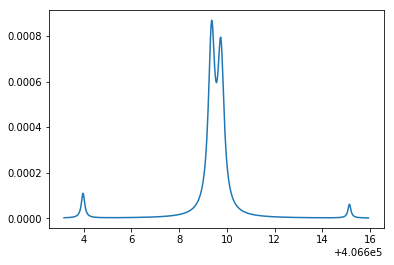

In [148]:
pops_tot = np.sum(pops,axis=1)
pops_tot = pops_tot

plt.plot(w_Ls/(2*pi), pops_tot)

p0 = (w_Ls[np.argmax(pops_tot)]/(2*pi), Gamma_opt, np.amax(pops_tot), 0)
fit_func = lorentzian
popt, pcov = cf(fit_func, w_Ls/(2*pi), pops_tot, p0=p0)
# plt.plot(w_Ls/(2*pi), fit_func(w_Ls/(2*pi), *popt), '-r')
print(Gamma_opt, popt[1], 1/(2*pi*popt[1]))

[1.81123495 0.99698672]


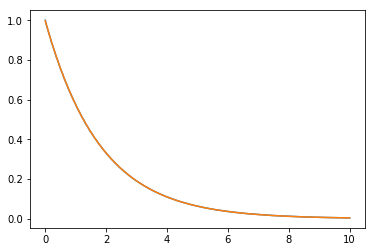

In [420]:
rho0 = evs_[4]*evs_[4].dag()
tlist = np.linspace(0,10,300)
fit_func = lambda t, tau, a: a*np.exp(-t/tau)
exp_ = mesolve(H, rho0, tlist, c_ops, rho0).expect[0]
plt.plot(tlist, exp_)
popt, pcov = cf(fit_func, tlist, exp_)
print(popt)
plt.plot(tlist, fit_func(tlist, *popt))